In [25]:
import pandas as pd
import numpy as np
import os
import gget
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sys
import umap
import itertools
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import scipy

import utils as ut

2023-06-01 12:07:20.148049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 12:07:28.515665: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2023-06-01 12:07:28.515682: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-01 12:07:29.277844: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-01 12:07:49.6156

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = lf.drop_duplicates(subset='cellId')
    lf = lf[lf['cellType'].isin(macTypes)]
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    

    cellIds = lf['cellId'].to_list()
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']

    rf = rf[rf.index.isin(cellIds)]
    print(f"{key=} {lf.shape=} {rf.shape}")
    
    rf = ut.normalize(rf, 1e6)
    rna[key] = rf
    

print('done')


ND...
key='ND' lf.shape=(360, 6) (359, 31053)
HFD8...
key='HFD8' lf.shape=(2194, 6) (2188, 31053)
HFD14...
key='HFD14' lf.shape=(3893, 6) (3884, 31053)
done


In [3]:
# merge all expression
rdf = []
for key in keys:
    rf = rna[key].copy()
    rf.index = rf.index + "_" + key
    rdf.append(rf)

rdf = pd.concat(rdf)
print(f"{rdf.shape=}")
rdf.head()

rdf.shape=(6431, 31053)


Unnamed: 0,XKR4,GM1992,GM37381,RP1,SOX17,GM37323,MRPL15,LYPLA1,GM37988,TCEA1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,VMN2R122,CAAA01147332.1
cellId,,,,,,,,,,,,,,,,,,,,,
AAAGAACGTCTACAGT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365.89828,...,0.0,0.0,0.0,0.0,0.0,0.0,365.89828,365.89828,0.0,0.0
AAAGAACTCCTCGCAT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1103.509159,220.701832,0.0,0.0
AAAGGGCGTTAGGGTG.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,111.994624,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.994624
AACAAAGCACCGGCTA.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,85.697146,0.0,0.0,0.0
AACAAAGGTTCACGAT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,331.619964,0.0,331.619964,...,0.0,0.0,0.0,0.0,0.0,0.0,331.619964,331.619964,0.0,0.0


In [4]:
""" Build the reference dataframe """
ref = []
for key in keys:
    lf = labels[key]
    ref.append(lf)

ref = pd.concat(ref, ignore_index=True)
ref = ref.rename(columns={'sampleInfo' : 'key'})
ref['id'] = ref['cellId'] + "_" + ref['key']
print(f"{ref.shape=}")
ref.head()

ref.shape=(6447, 7)


,cellId,cellType,key,x,y,colors,id
0,AAAGAACGTCTACAGT.1,Mac1,ND,3.089298,-1.726030,#fdbf6f,AAAGAACGTCTACAGT.1_ND
1,AAAGAACTCCTCGCAT.1,Mac1,ND,3.614130,-1.571004,#fdbf6f,AAAGAACTCCTCGCAT.1_ND
2,AAAGGGCGTTAGGGTG.1,Mac3,ND,3.086352,6.166065,#fdbf6f,AAAGGGCGTTAGGGTG.1_ND
3,AACAAAGCACCGGCTA.1,Mac3,ND,4.344001,5.801922,#fdbf6f,AACAAAGCACCGGCTA.1_ND
4,AACAAAGGTTCACGAT.1,Mac1,ND,0.130051,-1.583494,#fdbf6f,AACAAAGGTTCACGAT.1_ND


pdf.shape=(6479, 10)
P2RY12 gVec.max()=1485.88 gVec.mean()=15.97 np.median(gVec)=0.00
LYVE1 gVec.max()=4504.50 gVec.mean()=74.42 np.median(gVec)=0.00
MRC1 gVec.max()=9090.91 gVec.mean()=488.36 np.median(gVec)=210.67
CD74 gVec.max()=85826.53 gVec.mean()=14626.93 np.median(gVec)=10444.96
ITGAX gVec.max()=2541.30 gVec.mean()=115.28 np.median(gVec)=0.00
TREM2 gVec.max()=5988.02 gVec.mean()=1136.42 np.median(gVec)=941.68


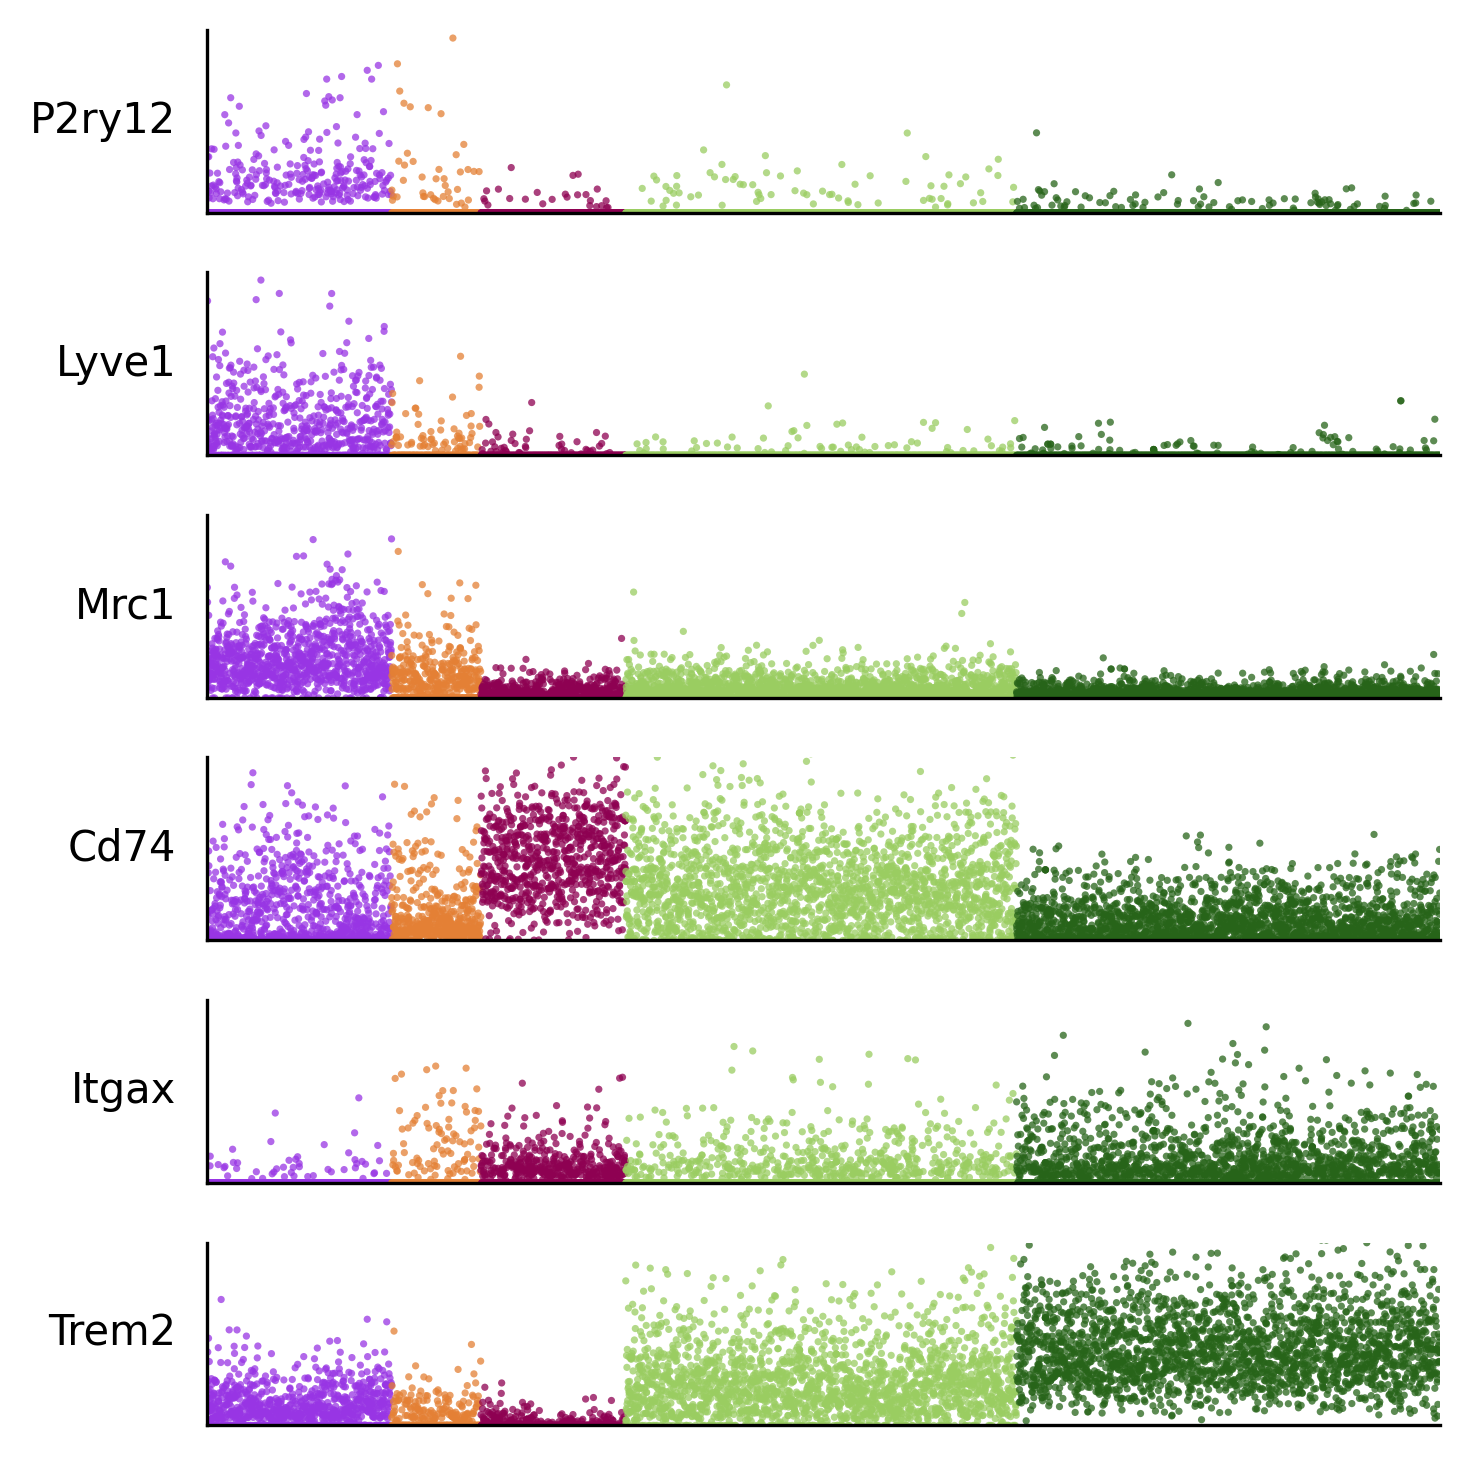

In [5]:
fontsize = 10

# get genes of interest
genes = [
    "P2RY12",
    "LYVE1",
    "MRC1",
    "CD74",
    # "PTPRC",
    # "timd4",
    "ITGAX",
    'TREM2',
]


genes = [x.upper() for x in genes]

# filter cell types
ctypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4', 
    'Mac5',
]

# map colors
cmapper = dict(zip(ctypes, ut.MACCOLORS))

# get the macrophages
ref = ref.sort_values(by='cellType')
cids = ref[ref['cellType'].isin(ctypes)]['id'].to_list()


pdf = rdf[rdf.index.isin(cids)].copy()
pdf = pdf[genes] # filter for just the genes

pdf = pdf.reindex(cids) # sort the rna by the cell ids
pdf = pdf.fillna(0)

# get plotting variables
pdf['num'] = np.arange(len(pdf))

# merge coloring
pdf = pd.merge(pdf, ref[['id', 'cellType']],
               how='left',
               left_index=True,
               right_on='id')

pdf['colors'] = pdf['cellType'].map(cmapper)

print(f"{pdf.shape=}")


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(len(genes), 1)
axs = axs.ravel()


for i, g in enumerate(genes):
    gVec = pdf[g].astype(float).to_numpy()
    print(f"{g} {gVec.max()=:.2f} {gVec.mean()=:.2f} {np.median(gVec)=:.2f}")
    gVec = sklearn.preprocessing.minmax_scale(gVec, feature_range=(0, 1))
    
    axs[i].scatter(pdf['num'], 
                   gVec, 
                   s=3,
                   c=pdf['colors'].to_list(),
                   ec='None',
                   alpha=0.75,
          )

    axs[i].set_xticks([])
    axs[i].set_ylabel(f"{g.lower().capitalize()}", 
                      rotation=0,
                      fontsize=fontsize,
                      verticalalignment='center',
                      horizontalalignment='right')
    axs[i].set_xlabel("")
    axs[i].set_xlim([0, pdf['num'].max()])
    axs[i].set_ylim([0, 1.1])
    # axs[i].set_yticks([0, gVec.max()], [0, f"{gVec.max():.1f}"])
    axs[i].set_yticks([])
    axs[i].set_facecolor('None')
    axs[i].set_ylim([0, 0.8])


plt.tight_layout()
sns.despine()

In [6]:
# [x for x in rdf.columns if "CD" in x]

In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [8]:
# filter cell types
ctypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4', 
    'Mac5',
]

res = []

genes = [x.strip().upper() for x in open("Han2017_splicing_factors.txt")]

cids = ref[ref['cellType'].isin(ctypes)]['id'].to_list()
pdf = rdf[rdf.index.isin(cids)].copy()

pdf = pd.merge(pdf, ref[['id', 'cellType']],
               how='left',
               left_index=True,
               right_on='id')


print(f"{pdf.shape=}")

pdf.shape=(6447, 31055)


In [9]:
res = []

for ct in ctypes:
    print(f"working {ct}...")
    mask = pdf['cellType'] == ct
    inDf = pdf[mask]
    outDf = pdf[~mask]

    for g in genes:
        score, pval = scipy.stats.ranksums(inDf[g], outDf[g],
                                           alternative='two-sided')

        lfc = np.log2(inDf[g].mean()+1) - np.log2(outDf[g].mean()+1)

        row = {
            'gene' : g,
            "cellType" : ct,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc,
        }
        res.append(row)

res = pd.DataFrame(res)
res.head()

working Mac1...
working Mac2...
working Mac3...
working Mac4...
working Mac5...


,gene,cellType,score,pval,log2foldchange
0,ACIN1,Mac1,-0.192268,0.847533,0.320064
1,ADAD1,Mac1,0.000000,1.000000,0.000000
2,ADAR,Mac1,-0.045344,0.963833,0.477477
3,ADARB1,Mac1,-0.499879,0.617160,-0.877717
4,ADARB2,Mac1,-0.009044,0.992784,-0.032073


Text(0.5, 11.166666666666647, 'Splicing Factor')

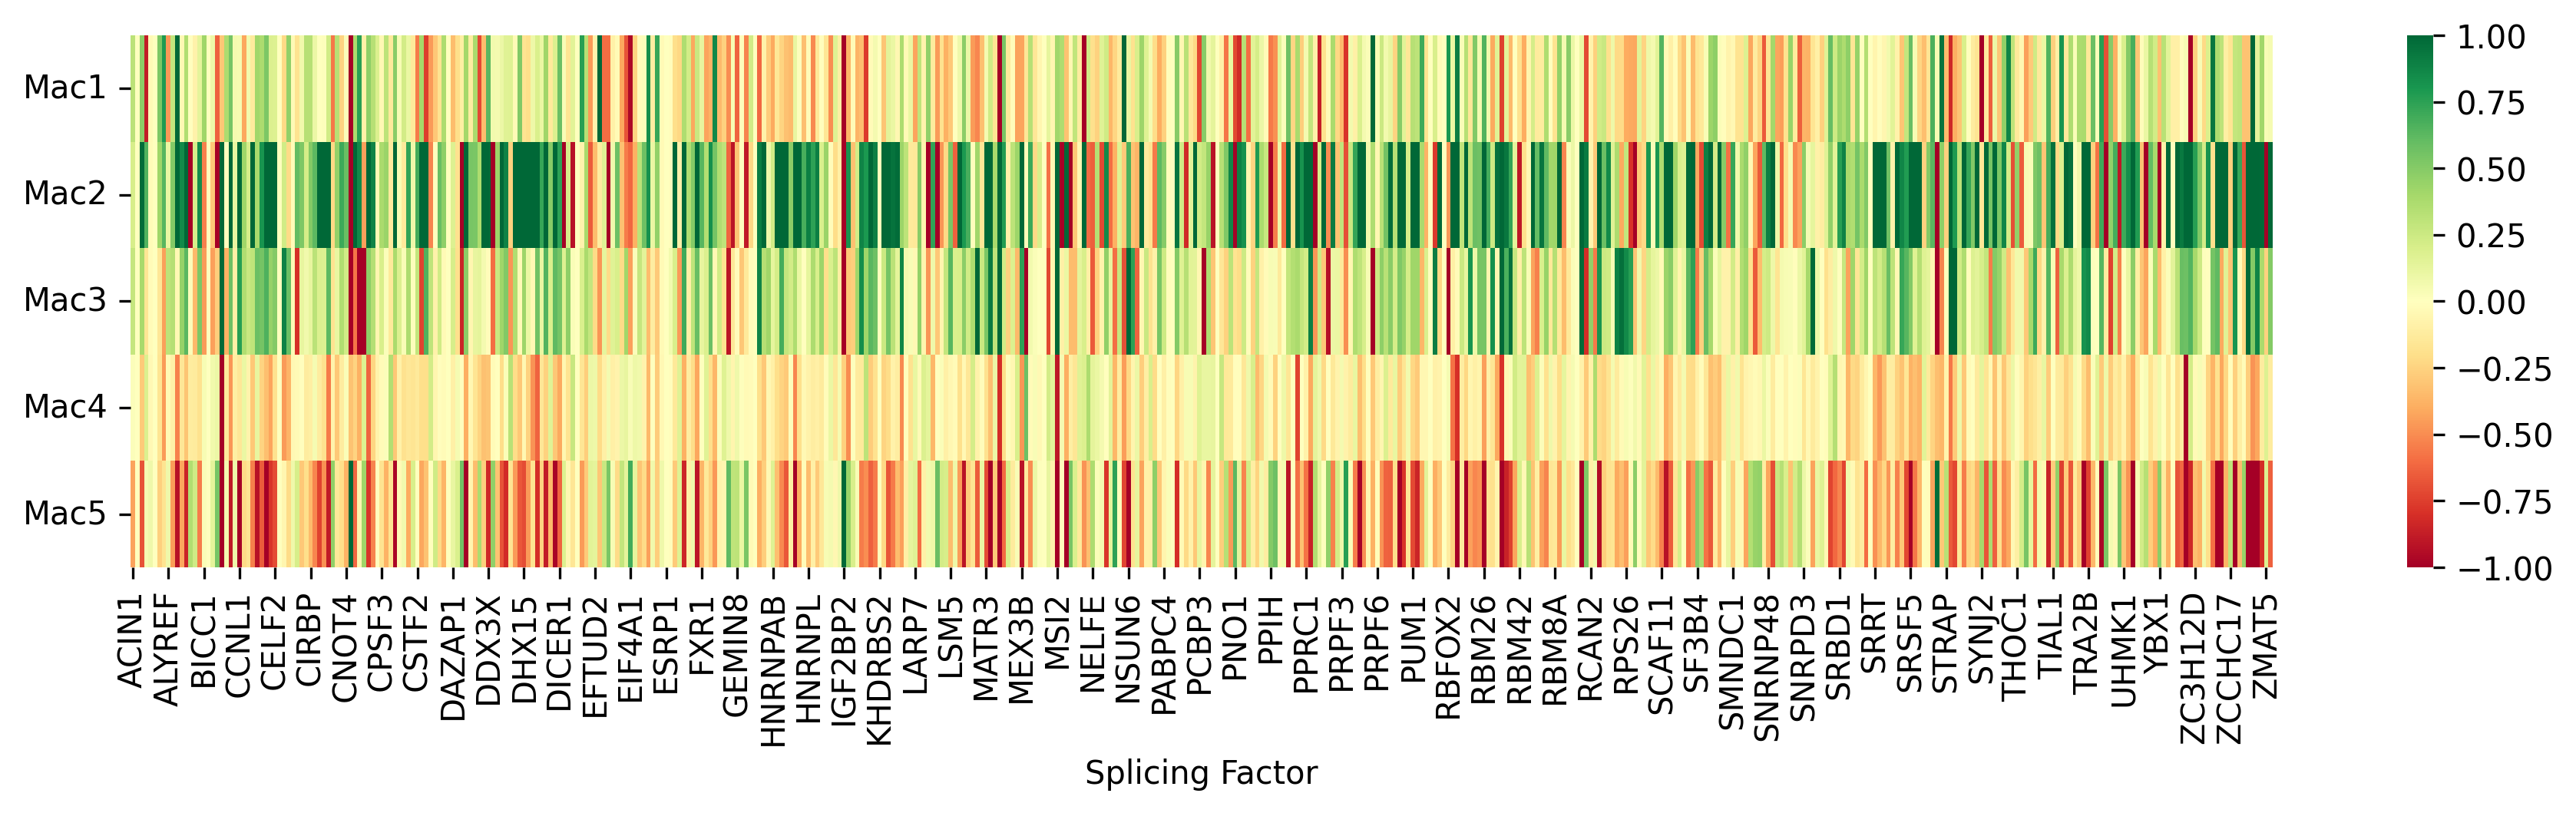

In [10]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 3


pdx = res.copy()
pdx = pd.pivot_table(pdx, 
                     index='cellType',
                     columns='gene',
                     values='log2foldchange')

sns.heatmap(data=pdx, 
            cmap='RdYlGn',
            vmin=-1,
            vmax=1,)

plt.yticks(rotation=0)
plt.ylabel("")
plt.xlabel("Splicing Factor")

alpha=0.05 ntests=482.0 0.00010641196105631856


Text(0.5, 11.166666666666647, 'Splicing Factor')

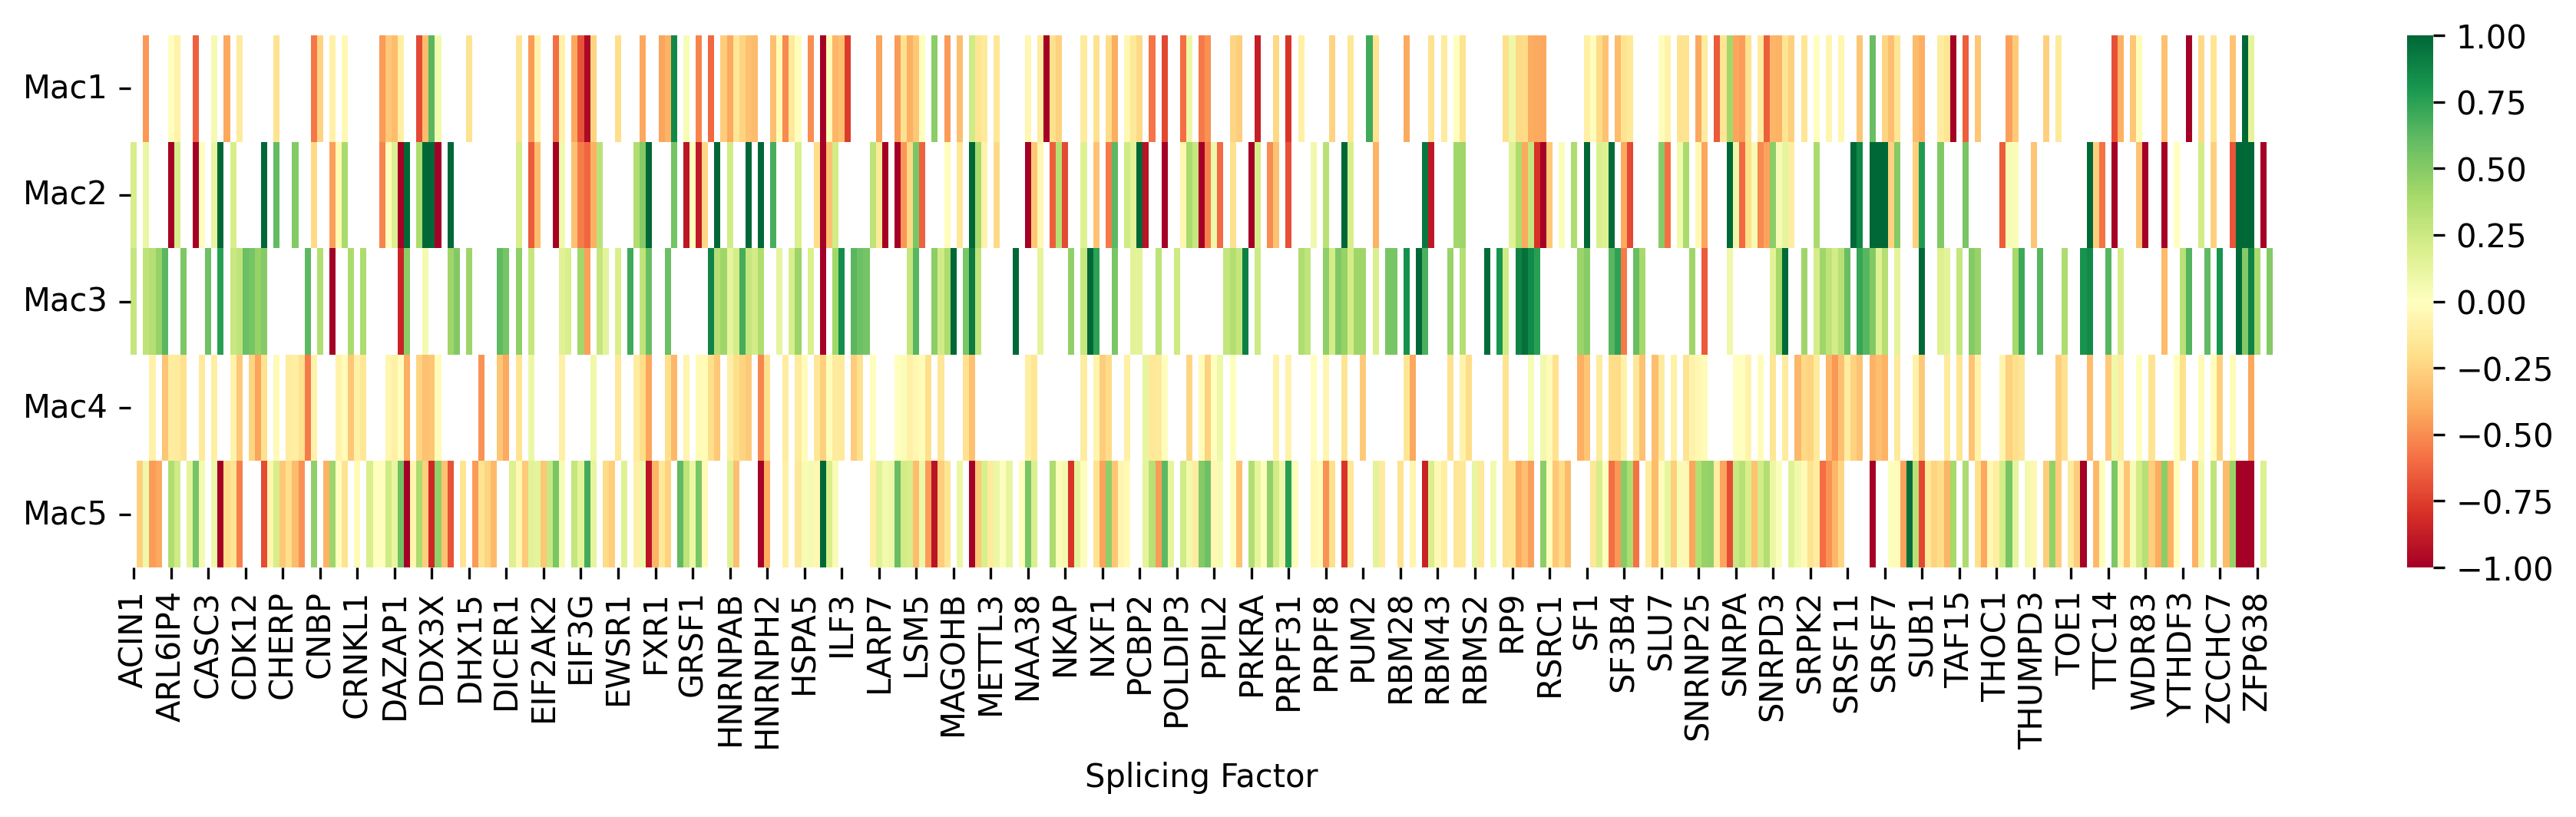

In [11]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 3


pdx = res.copy()

alpha = 0.05
ntests = len(res) / 5
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")

pdx = pdx[pdx['pval'] <= alphaHat]


pdx = pd.pivot_table(pdx, 
                     index='cellType',
                     columns='gene',
                     values='log2foldchange')

sns.heatmap(data=pdx, 
            cmap='RdYlGn',
            vmin=-1,
            vmax=1,)

plt.yticks(rotation=0)
plt.ylabel("")
plt.xlabel("Splicing Factor")

alpha=0.05 ntests=482.0 0.00010641196105631856
(5, 345)


Text(0.5, -100.4583333333332, '')

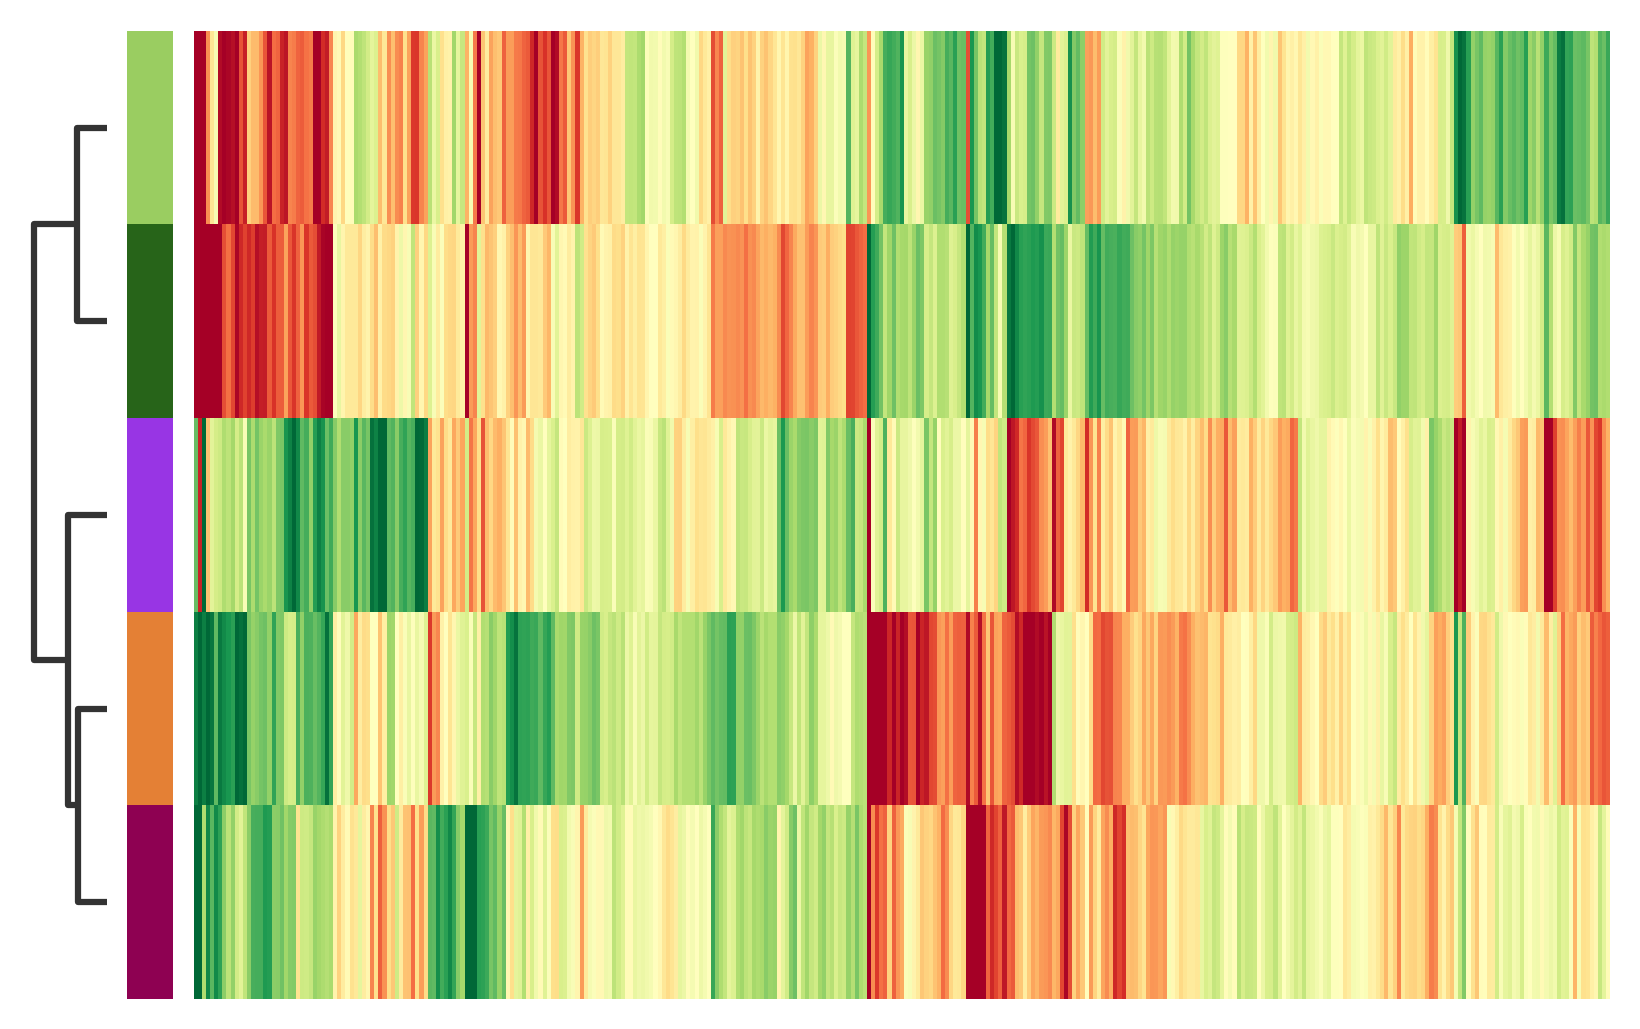

In [12]:
pdx = res.copy()

alpha = 0.05
ntests = len(res) / 5
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")

sigGenes = pdx[pdx['pval'] <= alphaHat]['gene'].unique()
pdx = pdx[pdx['gene'].isin(sigGenes)]

pdx = pd.pivot_table(pdx, 
                     index='cellType',
                     columns='gene',
                     values='log2foldchange')
print(pdx.shape)

g = sns.clustermap(pdx, 
               vmin=-2, 
               vmax=2,
               cmap='RdYlGn',
               method='ward',
               metric='euclidean',
               z_score=0,
               figsize=(6, 4.5),
               tree_kws={'linewidth' : 1.5},
               dendrogram_ratio=(.05, 0),
               row_colors=ut.MACCOLORS)

g.cax.set_visible(False)
g.ax_heatmap.set_ylabel("")
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_xlabel("")

cluster
2    130
4    100
3     80
1     34
5      1
Name: count, dtype: int64



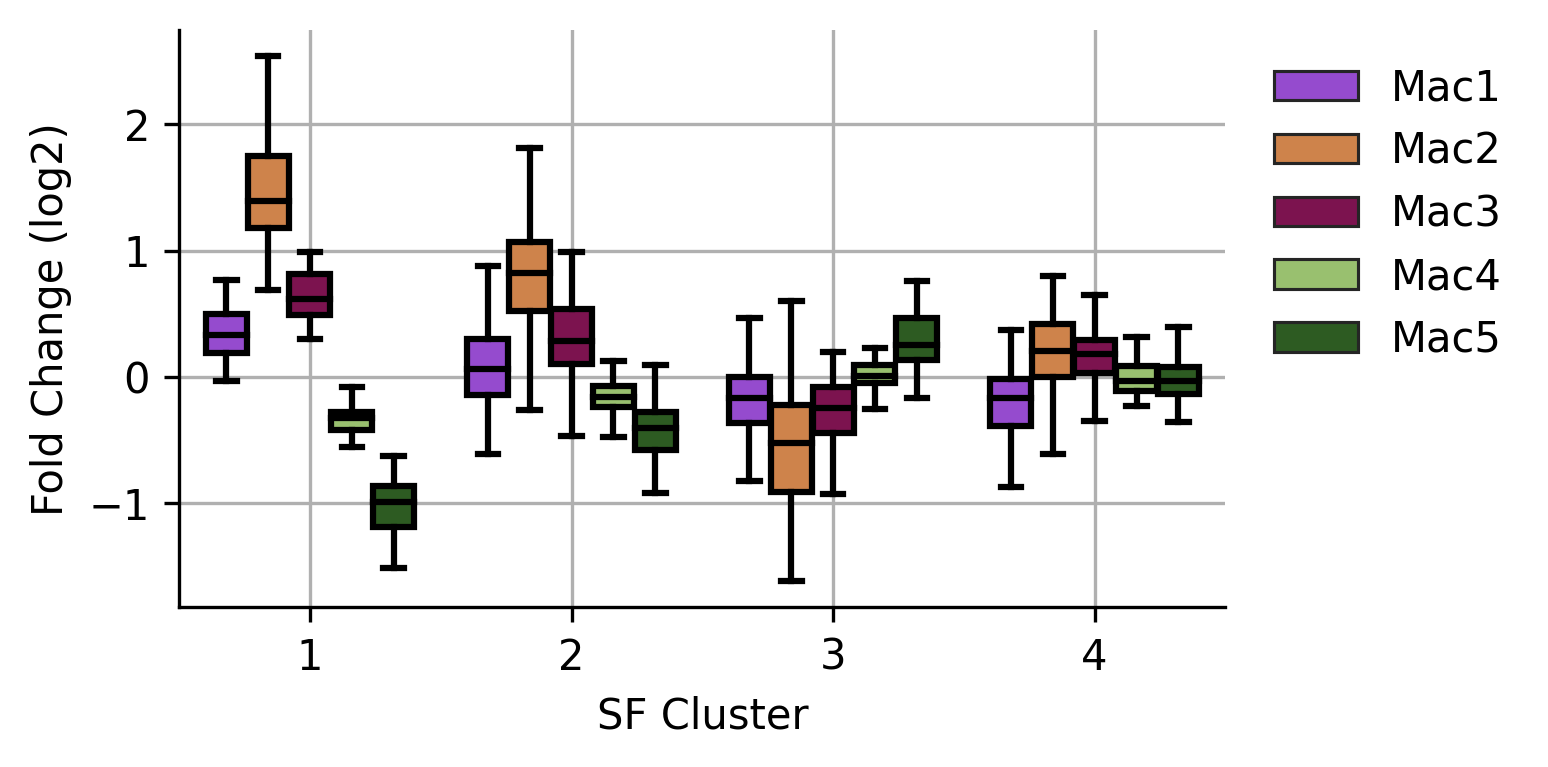

In [13]:
t = 5

clusterIds = scipy.cluster.hierarchy.fcluster(g.dendrogram_col.linkage, 
                                              t=t, 
                                              criterion='maxclust')


gdf = pd.DataFrame(zip(pdx.columns, clusterIds), columns=['gene', 'cluster'])

print(gdf['cluster'].value_counts())
print()

# get a dataframe to merge
mdf = res.copy()
mdf = mdf[mdf['gene'].isin(gdf['gene'].to_list())]
mdf.head()


mdf = pd.pivot_table(mdf, 
                     index='gene', 
                     columns='cellType', 
                     values='log2foldchange').reset_index(drop=False)


gdf = pd.merge(gdf, mdf, 
               how='left',
               left_on='gene',
               right_on='gene')

# drop low-count cluster
gdf = gdf[gdf['cluster'] != t]


gdf = pd.melt(gdf, id_vars=['gene', 'cluster'])


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.5, 2.5

PROPS = {
    'boxprops':{'edgecolor':'k', 'zorder':2},
    'medianprops':{'color':'k', 'zorder':2},
    'whiskerprops':{'color':'k','zorder':2},
    'capprops':{'color':'k', 'zorder':2},
    # "flierprops" : {'markerfacecolor' : 'k', 'markeredgecolor' : 'k'}
}

sns.boxplot(data=gdf, 
            x='cluster',
            y='value',
            hue='variable',
            palette=ut.MACCOLORS,
            showfliers=False,
            **PROPS,)

sns.move_legend(plt.gca(), 
                title='',
                loc='upper right',
                frameon=False, 
                bbox_to_anchor=(1.3, 1))

plt.ylabel("Fold Change (log2)")
plt.xlabel("SF Cluster")
# plt.axhline(y=0, c='k', lw=0.75, zorder=-10)
plt.grid(True, zorder=-10)
sns.despine()

Text(0.5, 0, 'UMAP 1')

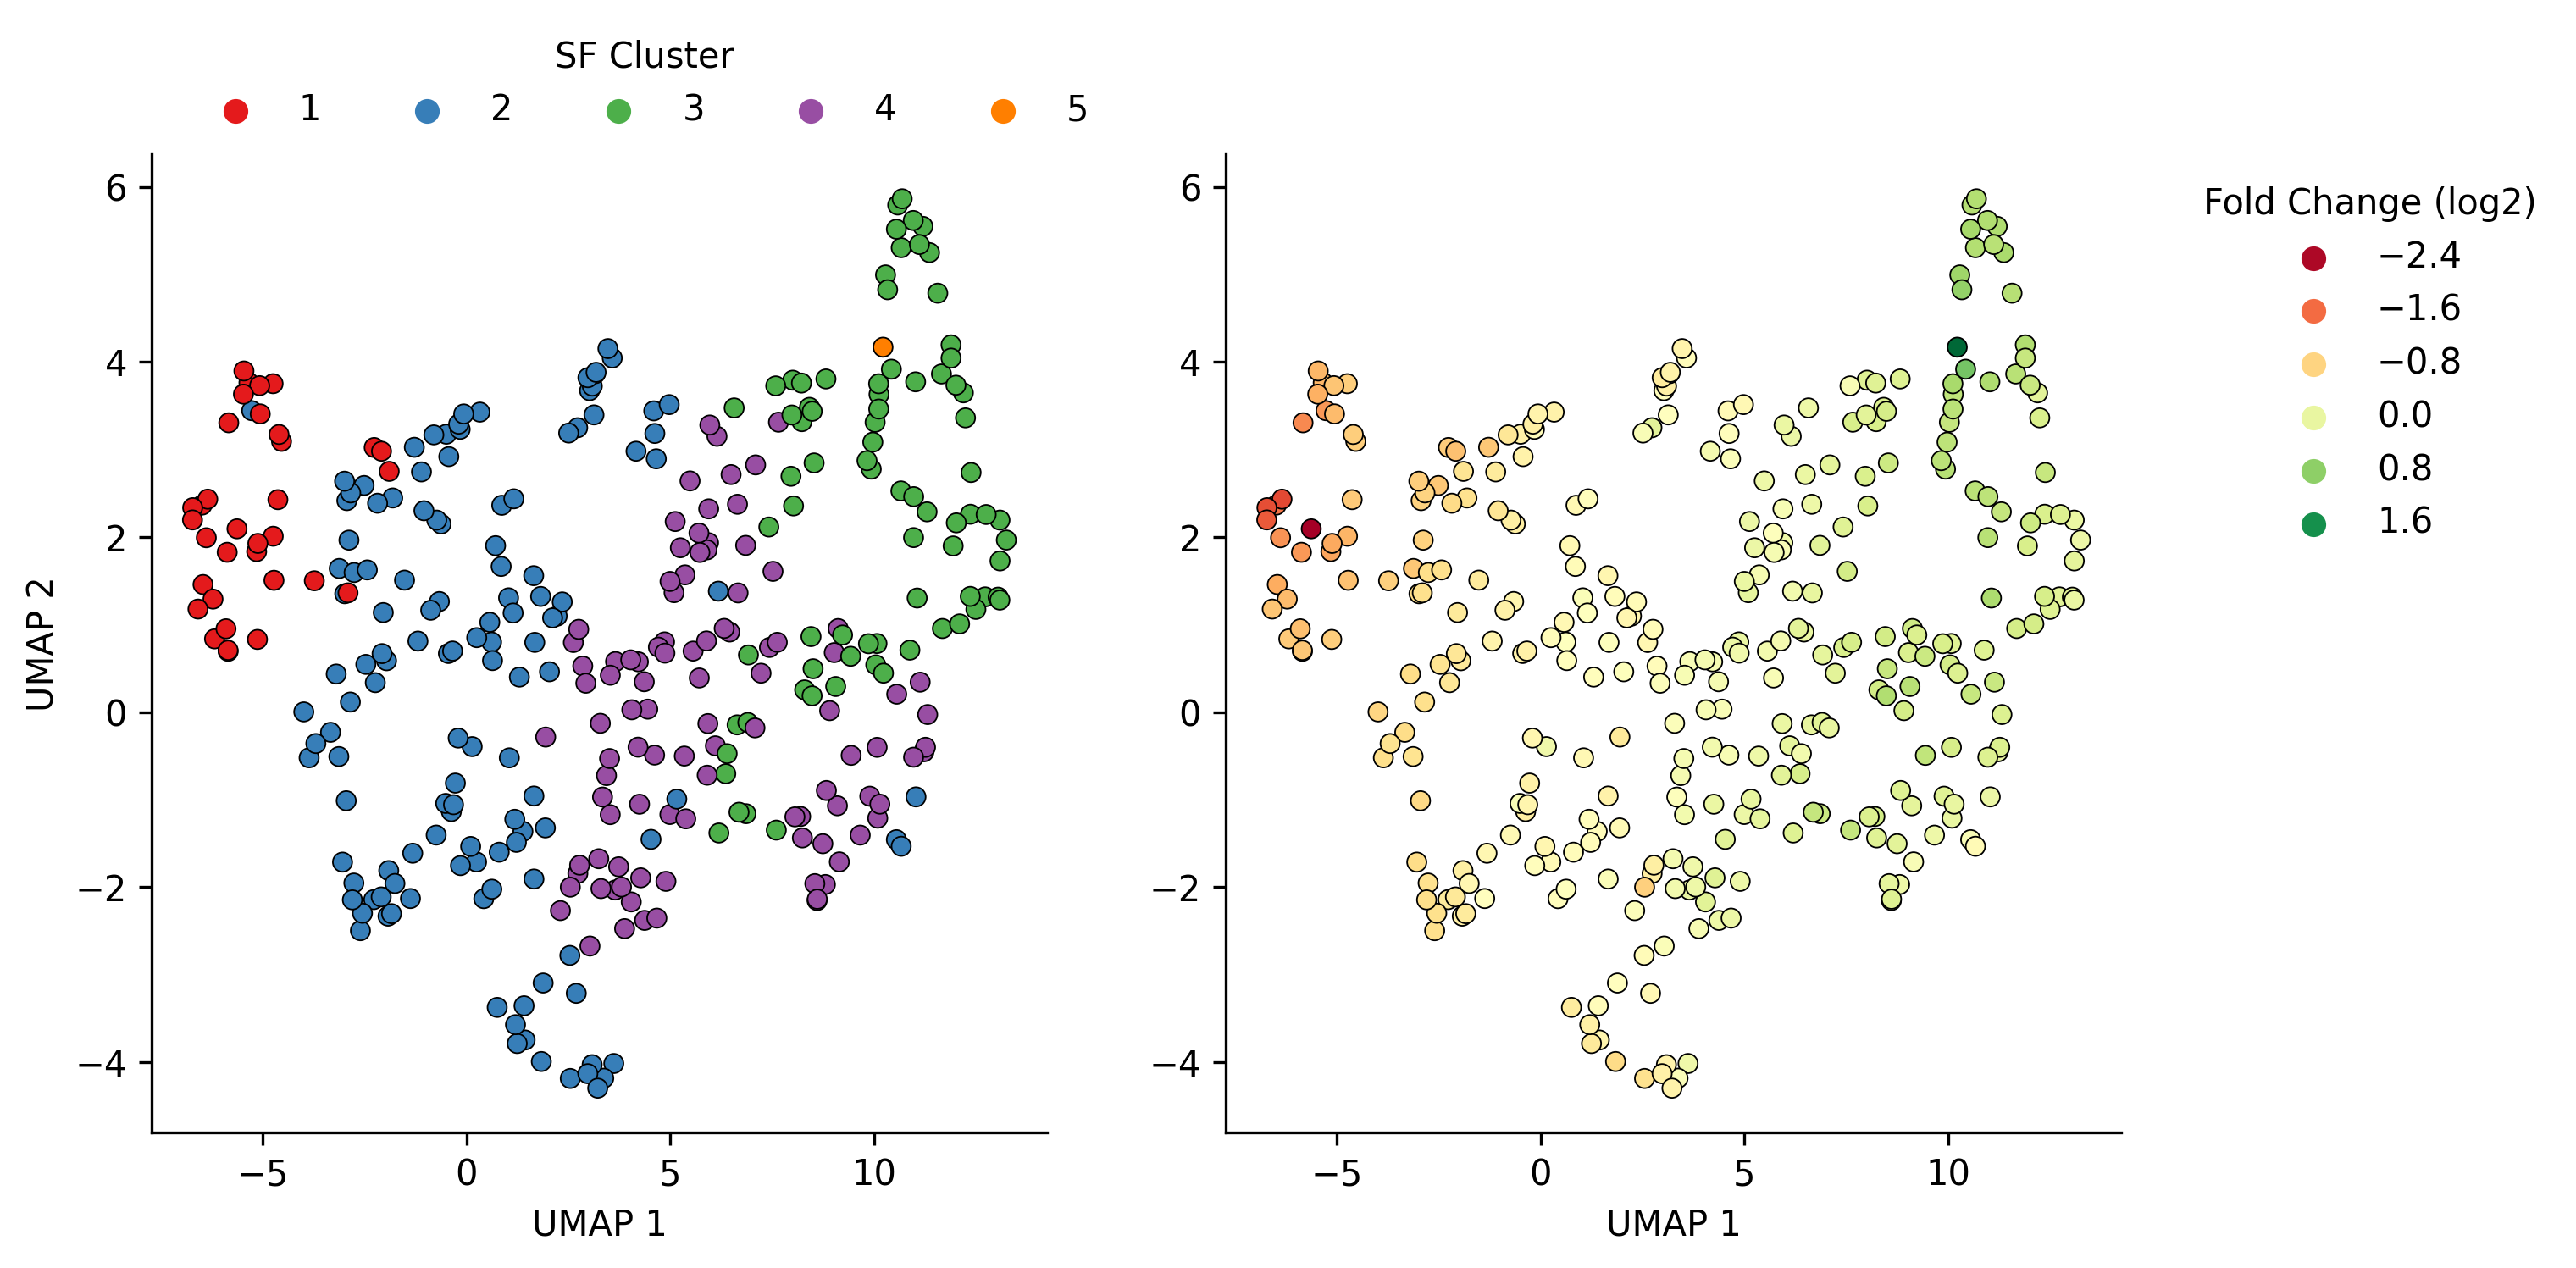

In [90]:
t = 5
tops = 10

clusterIds = scipy.cluster.hierarchy.fcluster(g.dendrogram_col.linkage, 
                                              t=t, 
                                              criterion='maxclust')


gdf = pd.DataFrame(zip(pdx.columns, clusterIds), columns=['gene', 'cluster'])

# get a dataframe to merge
mdf = res.copy()
mdf = mdf[mdf['gene'].isin(gdf['gene'].to_list())]
mdf.head()


mdf = pd.pivot_table(mdf, 
                     index='gene', 
                     columns='cellType', 
                     values='log2foldchange').reset_index(drop=False)


gdf = pd.merge(gdf, mdf, 
               how='left',
               left_on='gene',
               right_on='gene')


# plotting params
n_components = 2 # should always be 2
n_neighbors = 5
min_dist = 0.3
metric= "euclidean"

umap_reducer = umap.UMAP(n_components=n_components,
                         n_neighbors=n_neighbors,
                         min_dist=min_dist,
                         metric=metric)

embedding = umap_reducer.fit_transform(gdf[ctypes]) # we need embedding by cell
embedding = pd.DataFrame(embedding)
embedding.columns = ['x', 'y']

gdf = pd.concat([gdf, embedding], axis=1)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 5

fig, axs = plt.subplots(1, 2)
axs = axs.ravel()

sns.scatterplot(data=gdf, 
                x='x',
                y='y',
                ec='k',
                s=30,
                palette='Set1',
                hue='cluster',
                ax=axs[0])

sns.move_legend(axs[0],
                title="SF Cluster",
                frameon=False,
                loc='upper center',
                ncols=t,
                bbox_to_anchor=(0.55, 1.15),
               )
                


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.1, point['y']-0.05, str(point['val']), fontsize=3)

sns.despine()
axs[0].set_ylabel('UMAP 2')
axs[0].set_xlabel('UMAP 1')

gdf['gene'] = gdf['gene'].apply(lambda x: str(x).lower().capitalize())

# label_point(gdf['x'], gdf['y'], gdf['gene'], axs[0])


sns.scatterplot(data=gdf, 
                x='x',
                y='y',
                ec='k',
                s=30,
                palette='RdYlGn',
                vmin=-1,
                vmax=1,
                hue='Mac5',
                ax=axs[1])

sns.move_legend(axs[1],
                title="Fold Change (log2)",
                frameon=False,
                loc='upper right',
                bbox_to_anchor=(1.5, 1),
               )

axs[1].set_ylabel('')
axs[1].set_xlabel('UMAP 1')

cluster
2    130
4    100
3     80
1     34
5      1
Name: count, dtype: int64



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Stau2'),
  Text(1, 0, 'Prpf31'),
  Text(2, 0, 'Eif4a1'),
  Text(3, 0, 'Pno1'),
  Text(4, 0, 'Gemin6'),
  Text(5, 0, 'Lsm2'),
  Text(6, 0, 'Ppil1'),
  Text(7, 0, 'Ddx1'),
  Text(8, 0, 'C1qbp'),
  Text(9, 0, 'Thoc5'),
  Text(10, 0, 'Trmt2a'),
  Text(11, 0, 'Tfip11'),
  Text(12, 0, 'Thumpd3'),
  Text(13, 0, 'Rbm47'),
  Text(14, 0, 'Dgcr14')])

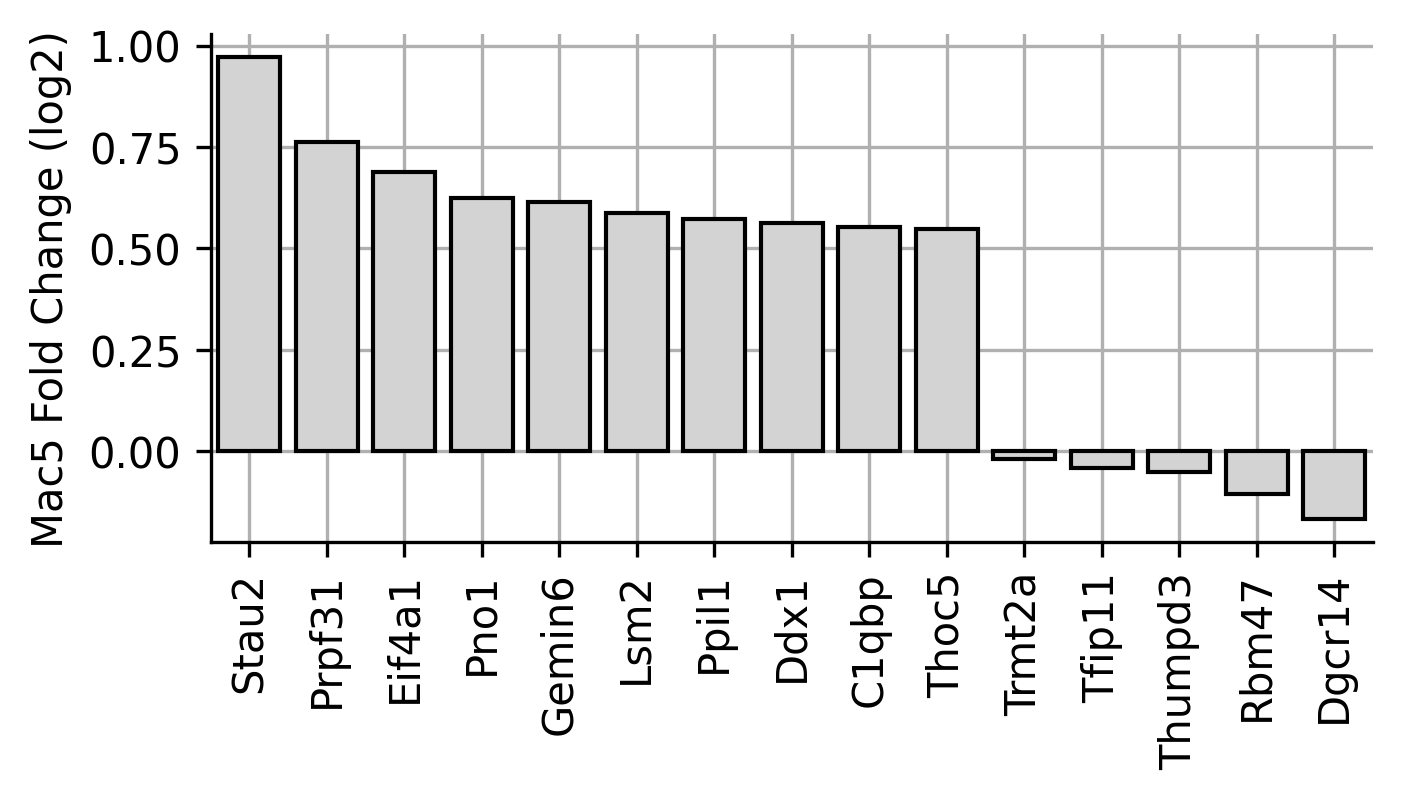

In [19]:
t = 5
tops = 10

clusterIds = scipy.cluster.hierarchy.fcluster(g.dendrogram_col.linkage, 
                                              t=t, 
                                              criterion='maxclust')


gdf = pd.DataFrame(zip(pdx.columns, clusterIds), columns=['gene', 'cluster'])

print(gdf['cluster'].value_counts())
print()

# get a dataframe to merge
mdf = res.copy()
mdf = mdf[mdf['gene'].isin(gdf['gene'].to_list())]
mdf.head()


mdf = pd.pivot_table(mdf, 
                     index='gene', 
                     columns='cellType', 
                     values='log2foldchange').reset_index(drop=False)


gdf = pd.merge(gdf, mdf, 
               how='left',
               left_on='gene',
               right_on='gene')

"""subset the LAM genes """
gdf = gdf[gdf['cluster'] == 3]
gdf = gdf.sort_values(by='Mac5', ascending=False)


# var switches to PDF here
pdf = pd.concat([gdf.head(10), gdf.tail(5)])

pdf['gene'] = pdf['gene'].apply(lambda x: str(x).lower().capitalize())
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 2.2

sns.barplot(data=pdf, 
            x='gene',
            y='Mac5',
            color='lightgrey',
            ec='k',
            zorder=2)

plt.grid(True, zorder=-10)
plt.ylabel("Mac5 Fold Change (log2)")
plt.xlabel("")
sns.despine()
plt.xticks(rotation=90)


In [14]:
?ut.makeColorbar



Signature: ut.makeColorbar(cmap, width, hieght, title, orientation, tickLabels)
Docstring: <no docstring>
File:      ~/git_repositories/spatial_transcriptomics/clustering/utils.py
Type:      function

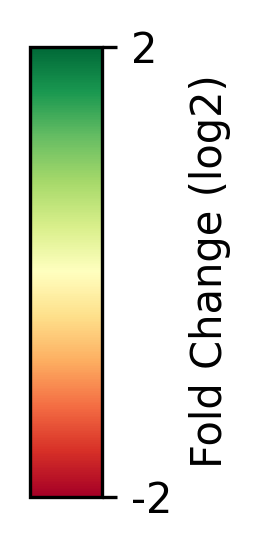

In [18]:
ut.makeColorbar('RdYlGn', 0.3, 2.5, 'Fold Change (log2)', 'vertical', [-2, 2])

In [ ]:
db = 'GO_Biological_Process_2023'
db = 'GO_Molecular_Function_2023'
db = 'KEGG_2019_Mouse'

query = gdf['gene'].head(10).to_list()

ef = gget.enrichr(query, database=db)
ef.head()

In [ ]:
?gget.enrichr

In [ ]:
# TFs that regulate splicing


In [ ]:
# sorted(gdf[gdf['cluster'] == 1]['gene'].to_list())

In [ ]:
[x for x in genes if "HN" in x]

In [ ]:
den = scipy.cluster.hierarchy.dendrogram(g.dendrogram_col.linkage,
                                         p=5,
                                         truncate_mode='level',
                                         labels = pdx.columns)

from collections import defaultdict

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = {}
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

clusters = get_cluster_classes(den)
clusters.keys()

In [ ]:


scipy.cluster.hierarchy.dendrogram(g.dendrogram_col.linkage,
                                   p=5,
                                   truncate_mode='level')


In [ ]:
dir(g)

In [ ]:
cols = genes + ['cellType']

gx = pdf[cols].groupby('cellType').mean()
gx = gx.astype(float)
gx = np.log1p(gx)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 3
plt.rcParams['figure.facecolor']
sns.heatmap(data=gx)

In [ ]:
break

In [ ]:
fontsize = 10

# get genes of interest
# genes = [
#     "MRC1",
#     'CD74',
#     'NR4A1',
#     "EGR1",
#     "TRAF1",
#     'MS4A7',
#     'TREM2',
# ]


genes = [
    "cd11c"
]

genes = [x.upper() for x in genes]

# filter cell types
ctypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4', 
    'Mac5',
]

# map colors
cmapper = dict(zip(ctypes, ut.MACCOLORS))

# get the macrophages
ref = ref.sort_values(by='cellType')
cids = ref[ref['cellType'].isin(ctypes)]['id'].to_list()


pdf = rdf[rdf.index.isin(cids)].copy()
pdf = pdf[genes] # filter for just the genes

pdf = pdf.reindex(cids) # sort the rna by the cell ids
pdf = pdf.fillna(0)

# get plotting variables
pdf['num'] = np.arange(len(pdf))

# merge coloring
pdf = pd.merge(pdf, ref[['id', 'cellType']],
               how='left',
               left_index=True,
               right_on='id')

pdf['colors'] = pdf['cellType'].map(cmapper)

print(f"{pdf.shape=}")


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 15
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(len(genes), 1)
axs = axs.ravel()


for i, g in enumerate(genes):
    gVec = pdf[g].astype(float).to_numpy()
    print(f"{g} {gVec.max()=:.2f} {gVec.mean()=:.2f} {np.median(gVec)=:.2f}")
    gVec = sklearn.preprocessing.minmax_scale(gVec, feature_range=(0, 1))
    
    axs[i].scatter(pdf['num'], 
                   gVec, 
                   s=3,
                   c=pdf['colors'].to_list(),
                   ec='None',
                   alpha=0.75,
          )

    axs[i].set_xticks([])
    axs[i].set_ylabel(f"{g.lower().capitalize()}", 
                      rotation=0,
                      fontsize=fontsize,
                      verticalalignment='center',
                      horizontalalignment='right')
    axs[i].set_xlabel("")
    axs[i].set_xlim([0, pdf['num'].max()])
    axs[i].set_ylim([0, 1.1])
    # axs[i].set_yticks([0, gVec.max()], [0, f"{gVec.max():.1f}"])
    axs[i].set_yticks([])
    axs[i].set_facecolor('None')


plt.tight_layout()
sns.despine()

In [ ]:
pdf.head()

In [ ]:
ref.head()

In [ ]:
# get cell ids







cid1 = ref[ref['cellType'] == 'Monocytes']['id'].to_list()
cid2 = ref[ref['cellType'] == 'Mac4']['id'].to_list()
cid3 = ref[ref['cellType'] == 'Mac5']['id'].to_list()
cids = cid1 + cid2 + cid3

n1 = len(cid1)
n2 = len(cid2)
n3 = len(cid3)


# type variables
c1 = ['yellow'] * n1
# c1 = ['orange'] * n1
c2 = ['#9acd61'] * n2
c3 = ['#276419'] * n3
colors = c1 + c2 + c3

xticks = [ (n1 // 2), (n1 + (n2 // 2)), (n1 + n2 + (n3//2)) ] 
xticklabels = ["Monocytes", "Mac4", "Mac5"]

# print(cid1[0])
# print(cid2[0])
# print(cids.index(cid2[0]))

print(f"{len(cid1)=} {len(cid3)=} {len(cid3)=}")

genes = [
    'CCR2',
    'Axl',
    # 'cx3cr1',
    # "nr4a1",
    # 'Ly6c2',
    # "Ms4a4c",
]

# genes = [
#     "Lgals3", 
#     "trem2",
#     "gpnmb",
#     "MS4A7",
#     "ctsl",
#     "mmp12",
# ]



genes = [x.upper() for x in genes]

pdf = rdf[rdf.index.isin(cids)]
pdf = pdf.reindex(cids) # sort the rna by the cell ids
pdf = pdf[genes]
pdf = pdf.fillna(0)
pdf['num'] = np.arange(len(pdf))
pdf['color'] = colors
print(f"{pdf.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3.5
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(len(genes), 1)
axs = axs.ravel()

fontsize = 12

for i, g in enumerate(genes):
    
    # gVec = np.log1p(pdf[g].astype(float).to_numpy())
    gVec = pdf[g].astype(float).to_numpy()
    print(f"{g} {gVec.max()=:.2f} {gVec.mean()=:.2f} {np.median(gVec)=:.2f}")
    gVec = sklearn.preprocessing.minmax_scale(gVec, feature_range=(0, 1))
    
    
#     axs[i].bar(pdf['num'], 
#                gVec, 
#                color=pdf['color'])
    
    axs[i].scatter(pdf['num'], 
           gVec, 
           s=2,
           color=pdf['color'],
           ec='k',
           lw=0.05,        
           alpha=0.8,
          )
    
    # axis formatting
    axs[i].set_xticks([])
    axs[i].set_ylabel(f"{g.lower().capitalize()}", 
                      rotation=0,
                      fontsize=fontsize,
                      verticalalignment='center',
                      horizontalalignment='right')
    axs[i].set_xlabel("")
    axs[i].set_xlim([0, pdf['num'].max()])
    axs[i].set_ylim([0, 1.1])
    # axs[i].set_yticks([0, gVec.max()], [0, f"{gVec.max():.1f}"])
    axs[i].set_yticks([])
    axs[i].set_facecolor('None')
    
plt.xticks(xticks, xticklabels, fontsize=fontsize)

    
sns.despine()
plt.tight_layout()